In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from dataset import LayoutDataset
from models import LayoutMLP
from scipy.stats import kendalltau

2023-10-19 21:23:16.838621: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-19 21:23:17.598965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
batch_size = 160
learning_rate = 5e-4
batch_per_file_size = 8
decay_rate = 0.95
node_embedding_size = 12
layers = [8, 8, 32, 8]

dataset = LayoutDataset(
    batch_size, train_sample_fraction=1.0,
    subset='nlp:default', build_tfrecords=False,
    batch_per_file_size=batch_per_file_size
)

2023-10-19 21:23:18.505092: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-19 21:23:18.539138: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-19 21:23:18.539408: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
mlp = LayoutMLP(
    batch_size,
    learning_rate=learning_rate,
    mask_max_len=dataset.n_config_nodes_upper_limit,
    batch_per_file_size=batch_per_file_size,
    decay_rate=decay_rate,
    node_embedding_size=node_embedding_size,
    validation_frequency=10_000,
    validations_without_improvement=3,
    layer_sizes=layers,
    loss='pairwise_hinge',
    l1_multiplier=1e-9,
    n_siblings=dataset.n_siblings
)

mlp.train(dataset, None)

2023-10-19 21:24:45.814730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-19 21:24:45.841842: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f97423b1d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-19 21:24:45.841860: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-10-19 21:24:45.845245: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-19 21:24:46.010351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-19 21:24:46.115020: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

iteration 500 training loss 2.636501 lr 0.00025
iteration 1000 training loss 2.6597784 lr 0.00050
iteration 1500 training loss 2.3854322 lr 0.00050
iteration 2000 training loss 2.220868 lr 0.00050
iteration 2500 training loss 2.3260705 lr 0.00050
iteration 3000 training loss 2.035022 lr 0.00050
iteration 3500 training loss 2.388977 lr 0.00050
iteration 4000 training loss 2.196218 lr 0.00050
iteration 4500 training loss 2.2990992 lr 0.00049
iteration 5000 training loss 2.127088 lr 0.00049
iteration 5500 training loss 2.3331206 lr 0.00049
iteration 6000 training loss 2.3105214 lr 0.00049
iteration 6500 training loss 1.9412616 lr 0.00049
iteration 7000 training loss 2.1269343 lr 0.00048
iteration 7500 training loss 2.320389 lr 0.00048
iteration 8000 training loss 1.9900949 lr 0.00048
iteration 8500 training loss 1.9351807 lr 0.00047
iteration 9000 training loss 1.9651728 lr 0.00047
iteration 9500 training loss 1.9718473 lr 0.00047
iteration 10000 training loss 2.1044548 lr 0.00046
layout:

iteration 76000 training loss 1.7722541 lr 0.00001
iteration 76500 training loss 1.8555559 lr 0.00001
iteration 77000 training loss 1.8429952 lr 0.00001
iteration 77500 training loss 2.0101628 lr 0.00001
iteration 78000 training loss 1.9864522 lr 0.00001
iteration 78500 training loss 1.7637435 lr 0.00001
iteration 79000 training loss 1.9545958 lr 0.00001
iteration 79500 training loss 1.9444544 lr 0.00001
iteration 80000 training loss 1.8572594 lr 0.00001
layout:nlp:default 0.44143339547714555
epoch 4, it 80000 validation loss -0.441
iteration 80500 training loss 2.1024194 lr 0.00001
iteration 81000 training loss 1.9887525 lr 0.00001
iteration 81500 training loss 1.7633644 lr 0.00001
iteration 82000 training loss 1.7466575 lr 0.00001
iteration 82500 training loss 2.0644932 lr 0.00001
iteration 83000 training loss 2.2318385 lr 0.00001
iteration 83500 training loss 2.1534781 lr 0.00001
iteration 84000 training loss 1.8898114 lr 0.00001
iteration 84500 training loss 1.7967051 lr 0.00001
it

KeyboardInterrupt: 

## Evaluate validation set

In [4]:
val_df = mlp.predict_over_dataset(dataset.valid_data, return_labels=True)

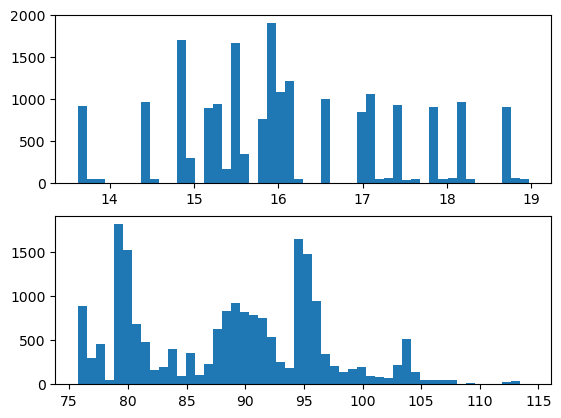

In [5]:
plt.subplot(2, 1, 1)
plt.hist(val_df['target'], bins=50)
plt.subplot(2, 1, 2)
plt.hist(val_df['prediction'], bins=50);

In [6]:
val_df.groupby('ID').apply(lambda x: x.min()).sort_values('prediction')

,ID,config_index,prediction,target
ID,,,,
b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-768_A-12_batch_size_16_test',b'layout:nlp:default:small_bert_bert_en_uncase...,244,75.729523,14.892140
b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-512_A-8_batch_size_64_test',b'layout:nlp:default:small_bert_bert_en_uncase...,46,75.814232,15.479798
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-512_A-8_batch_size_64_test',b'layout:nlp:default:small_bert_bert_en_uncase...,23,78.783249,15.940182
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-768_A-12_batch_size_32_test',b'layout:nlp:default:small_bert_bert_en_uncase...,158,78.858536,15.972469
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_32_test',b'layout:nlp:default:small_bert_bert_en_uncase...,428,79.041191,14.371652
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_32_test',b'layout:nlp:default:small_bert_bert_en_uncase...,39,79.442444,13.623108
b'layout:nlp:default:bert_en_cased_L-12_H-768_A-12_batch_size_16_test',b'layout:nlp:default:bert_en_cased_L-12_H-768_...,6,79.978058,15.544790
b'layout:nlp:default:small_bert_bert_en_uncased_L-2_H-256_A-4_batch_size_32_train',b'layout:nlp:default:small_bert_bert_en_uncase...,54,83.590210,14.869666
b'layout:nlp:default:small_bert_bert_en_uncased_L-4_H-512_A-8_batch_size_32_train',b'layout:nlp:default:small_bert_bert_en_uncase...,52,87.191315,16.100910


Text(0.5, 1.0, "b'layout:nlp:default:small_bert_bert_en_uncased_L-2_H-256_A-4_batch_size_32_train'")

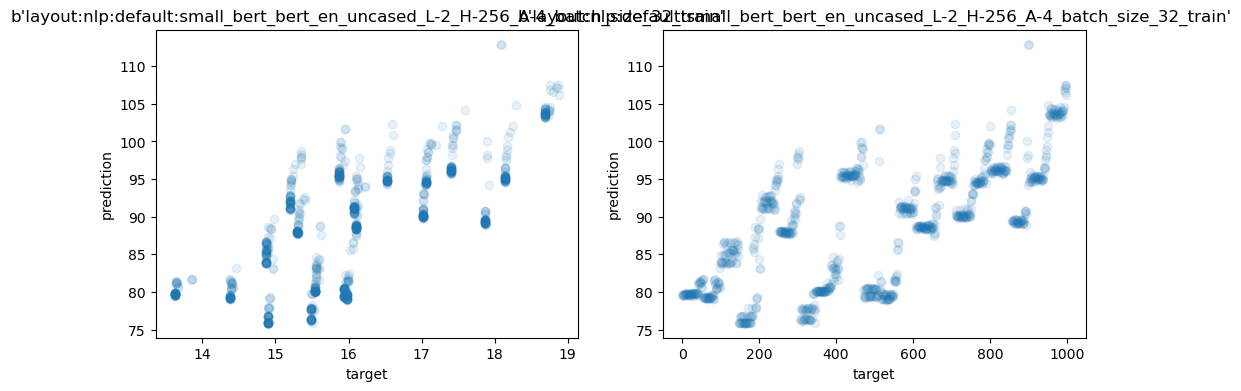

In [39]:
x_lin = np.linspace(15, 25, 100)
#plt.plot(x_lin, x_lin, color='orange')

random_sample = val_df.sample(1_000)
graph_id = np.random.choice(val_df['ID'].unique())
#graph_id = b'layout:xla:default:inception_v3_batch_128_train'
#graph_id = b'layout:xla:default:unet_3d.4x4.bf16'
#random_sample = val_df[val_df['ID'] == graph_id].copy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample.target,
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

random_sample.sort_values('target', inplace=True)
plt.subplot(1, 2, 2)
plt.scatter(
    np.arange(len(random_sample)),
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

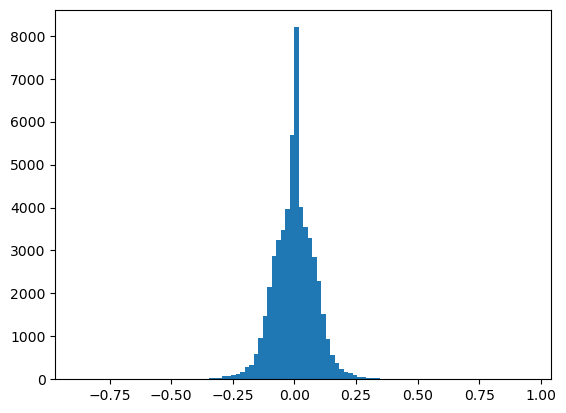

In [28]:
plt.hist(mlp.k_layer.kernel.numpy().flatten(), bins=100);

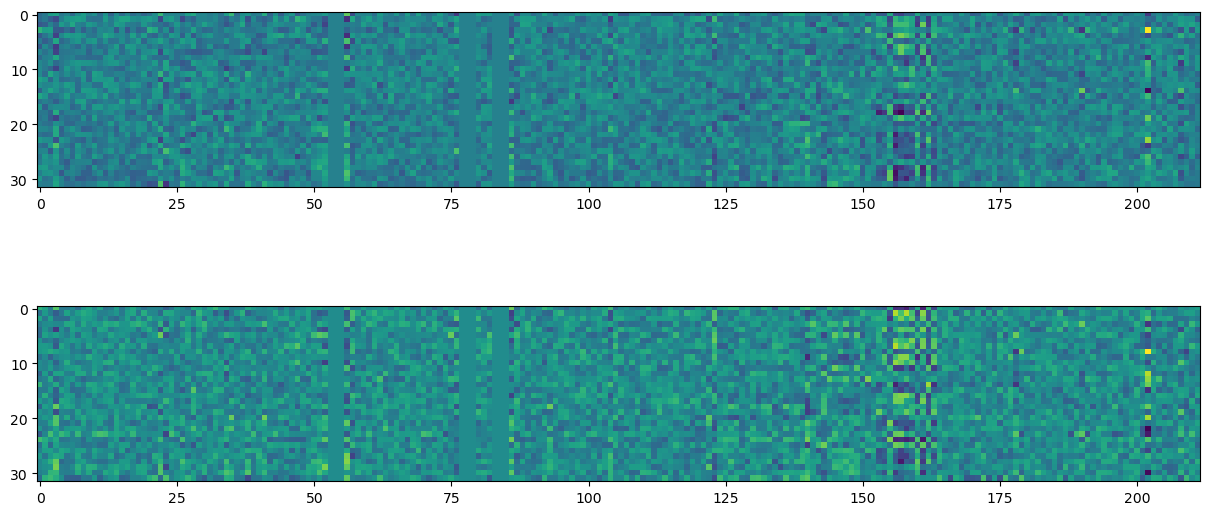

In [48]:
plt.figure(figsize=(15, 7))
kind = 1
plt.subplot(2, 1, 1)
k_vals = mlp.k_layer.kernel.numpy().reshape(212, 8, 32)[:, kind, :].T
plt.imshow(k_vals)

plt.subplot(2, 1, 2)
q_vals = mlp.q_layer.kernel.numpy().reshape(212, 8, 32)[:, kind, :].T
plt.imshow(q_vals)

00        interesting features (20)
            np.arange(21, 27),  # shape dims
            np.arange(31, 37),  # reshape/broadcast dims
            np.arange(95, 99),  # conv dims input
            np.arange(101, 105),  # conv dims kernel
20        parent output shapes (12)
32        sibling shapes (n_siblings*6)
50        physical layout (6)
56        node layout (18)
74        parent phys layout (12)
86        siblings layout (n_sibling*18)
140        parent opcodes (2)
164        sibling opcodes (n_siblings)
200        opcode (1)

In [74]:
lens = [20, 12, 18, 6, 18, 12, 18*3, 24, 36, 12]
np.cumsum(lens)

array([ 20,  32,  50,  56,  74,  86, 140, 164, 200, 212])

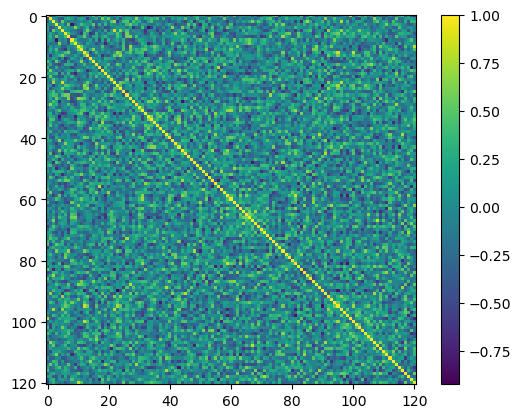

In [61]:
emb = mlp.embedding_layer_node_ops.weights[0].numpy()
emb = emb / np.expand_dims(np.linalg.norm(emb, axis=1), axis=-1)
dots = np.matmul(emb, emb.T)
plt.imshow(dots)
plt.colorbar()

In [ ]:
dots[34, 26]

In [52]:
np.argsort(dots[26])

array([ 59,  81,  32,  45,  87,  55,  31,  61,  41,  83,  50,  25,   9,
       112,  10,   8,  37,  52, 120, 110,  60,  11,  63, 118,  56,  80,
        49,  13, 106,  62,   4, 109,  15,  70,  71,  58,  90,  35,  72,
        14,  57,  93,   0,  17,  40,  48,  91,  44, 101,  33,  69,  65,
       113,  36,  74,  27,  18,  88,  46,  43,  66,  67,  16,  84,  23,
       119,  68,  24,  30, 117,  79,  99, 105,  97, 107,  53,  20, 100,
        42,  39, 102,  47, 114,  38,  86,  64, 115,  94,  28,  12, 103,
        51,  76,  29,  95, 104, 111,  78, 108,   1,  19,  82,  85,   3,
       116,   5,  77,  21,  75,   6,  34,   7,  22,  73,  92,  54,  26,
        98,  89,   2,  96])

In [60]:
ind = np.unravel_index(np.argsort(dots.flatten())[-8], dots.shape)
ind

(96, 2)

In [ ]:
val_df[val_df['ID'] == b'layout:xla:default:unet_3d.4x4.bf16'].sort_values('target')

In [ ]:
for val_batch in dataset.valid_data:
    if b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy():
        print(val_batch['layout_id'])
        break

In [ ]:
np.unique(val_batch['layout_id'].numpy())

In [ ]:
b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy()

In [ ]:
layout_ids = val_batch['layout_id']
config_descriptor = val_batch['node_descriptor']
valid_mask = val_batch['valid_nodes']
graph_descriptor = val_batch['graph_descriptor']

with tf.device('/cpu:0'):
    subset_info_str = tf.map_fn(
        lambda layout_id: tf.strings.reduce_join(
            tf.strings.split(layout_id, ":")[:3]),
        layout_ids
    )

subset_info = mlp.text_vectorization(subset_info_str)
subset_info = tf.expand_dims(subset_info, axis=-1)
subset_info = mlp.embedding_layer_subset_info(subset_info)
subset_info = subset_info[:, 0, :]

# for si, sn in zip(subset_info_str.numpy(), subset_info.numpy()):
#     print(si, sn)

node_operations = config_descriptor[:, :, -1]
config_descriptor = config_descriptor[:, :, :-1]
node_operations = tf.cast(node_operations, tf.int32)
# node_operations.shape == (batch_size, mask_max_len)                                                                                                                                 
node_embedding = mlp.embedding_layer_node_ops(node_operations)
# node_embedding.shape == (batch_size, mask_max_len, embed_len)
# np.unique(node_operations.numpy().flatten(), return_counts=True)

x = mlp.normalization_layer_config_nodes(config_descriptor)
normal_graph_descriptor = mlp.normalization_layer_graph_descriptor(graph_descriptor)
x = tf.concat([x, node_embedding], axis=-1)

x = mlp.dense_layer_node_1(x)
x = mlp.relu_layer(x)  # (batch_size, n_config_nodes_upper_limit, n_units)                                                                                                           
x = mlp.dense_layer_node_2(x)
x = mlp.relu_layer(x)  # (batch_size, n_config_nodes_upper_limit, n_units)                                                                                                           

# plt.hist(x.numpy().flatten(), bins=100);
float_mask = tf.sequence_mask(valid_mask, mlp.mask_max_len, dtype=tf.float32)
# (batch_size, n_config_nodes_upper_limit)                                                                                                                                            

float_mask = tf.expand_dims(float_mask, axis=-1)
x = x * float_mask

x = tf.reduce_sum(x, axis=1)
#plt.subplot(2, 1, 1)
#plt.hist(x.numpy().flatten(), bins=100);

x = x / tf.expand_dims(tf.cast(valid_mask, tf.float32), axis=-1)
#plt.subplot(2, 1, 2)
#plt.hist(x.numpy().flatten(), bins=100);
for i, lid, gd, nd in zip(range(96), layout_ids.numpy(), graph_descriptor.numpy(), normal_graph_descriptor.numpy()):
    if i in [19]:
        print(i, gd[80:90], nd[80:90], lid)
x = tf.concat([x, normal_graph_descriptor, subset_info], axis=-1)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_1(x)
x = mlp.relu_layer(x)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_2(x)
x = mlp.relu_layer(x)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_3(x)
x = tf.reshape(x, (-1,))
x

In [ ]:
random_sample = val_df.sample(5_000)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample['target'],
    np.abs(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('abs error')
x_lin = np.linspace(0, 0.7, 100)
#plt.plot(x_lin, x_lin, color='orange')


plt.subplot(1, 2, 2)
plt.scatter(
    random_sample['target'],
    np.square(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('squared error')

In [33]:
def sort_configs(df):
    top = df.sort_values('prediction')
    top = top['config_index'].values.tolist()
    top = [str(i) for i in top]
    return ';'.join(top)

val_prediction = val_df.groupby('ID').apply(sort_configs)
val_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
val_prediction

ID
layout:nlp:default:albert_en_xlarge_batch_size_16_test                               35867;452;34193;35044;33678;25980;33351;53008;...
layout:nlp:default:bert_en_cased_L-12_H-768_A-12_batch_size_16_test                  81539;34932;37925;26319;88202;57883;34785;6057...
layout:nlp:default:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train              7997;7954;7903;7693;7746;7697;7938;7693;3693;1...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_32_test      52261;63076;33621;77558;85911;3829;63068;3838;...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train     45520;12406;13260;13252;24329;13263;47079;1300...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_32_test      35375;31098;90462;91567;43307;11208;56151;5740...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train     1034;986;1003;1059;1113;42325;1312;1127;1215;2...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H

In [ ]:
val_df

In [ ]:
val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3])).unique()

In [34]:
def compute_layout_score_group(df):
    score, _ = kendalltau(df['prediction'], df['target'])
    return score

val_df['subset'] = val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3]))
for subset in val_df['subset'].unique():
    mean = np.mean(val_df[val_df['subset'] == subset].groupby('ID').apply(compute_layout_score_group))
    print(subset, mean)

layout:nlp:default 0.43724164218609596


In [36]:
np.mean([0.4185, 0.8167, 0.538, 0.2525])

0.506425

In [35]:
val_scores = val_df.groupby('ID').apply(compute_layout_score_group)
val_scores.sort_values()

ID
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-512_A-8_batch_size_64_test'      0.255395
b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-512_A-8_batch_size_64_test'       0.314122
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train'     0.345970
b'layout:nlp:default:small_bert_bert_en_uncased_L-4_H-512_A-8_batch_size_32_train'      0.356121
b'layout:nlp:default:talking-heads_large_batch_size_16_train'                           0.368010
b'layout:nlp:default:albert_en_xlarge_batch_size_16_test'                               0.369674
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train'     0.381771
b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train'      0.427276
b'layout:nlp:default:small_bert_bert_en_uncased_L-2_H-256_A-4_batch_size_32_train'      0.438341
b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_64_train'      0.441445
b'layout:nlp:default:bert_m

In [ ]:
def layout_score(candidate_order, layout_dict):
    runtimes = layout_dict['config_runtime']
    best_ranking = np.argsort(runtimes)
    assert len(candidate_order) == len(runtimes)
    score, _ = kendalltau(candidate_order, best_ranking)
    return score

In [ ]:
dirpath, filename

In [ ]:
true_order = np.argsort(layout_dict['config_runtime'])
plt.scatter(true_order, candidate_order)

In [ ]:
layout_set = 'valid'
true_orders = []
layout_ids = []
for dirpath, dirnames, filenames in os.walk('predict-ai-model-runtime/npz_all/npz/layout'):
    if len(filenames) == 0:
        continue
    
    if dirpath.split('/')[-1] != layout_set:
        continue
        
    layout_id_prefix = ':'.join(dirpath.split('/')[-4:-1])
    for filename in os.listdir(dirpath):
        print(filename)
        layout_id = layout_id_prefix+':'+filename[:-4]
        layout_dict = dict(np.load(os.path.join(dirpath, filename)))
        runtimes = layout_dict['config_runtime']
        best_ranking = np.argsort(runtimes)
        best_ranking = ';'.join([str(i) for i in best_ranking])
        true_orders.append(best_ranking)
        layout_ids.append(layout_id)
        
true_order_df = pd.DataFrame(
    data=np.stack([layout_ids, true_orders], axis=-1),
    columns=['ID', 'true_order']
)
true_order_df

In [ ]:
# layout_id = true_order_df.sample()['ID'].values[0]
layout_id = 'layout:xla:default:resnet50.4x4.fp16'
true_order = [int(i) for i in true_order_df[true_order_df['ID'] == layout_id]['true_order'].values[0].split(';')]
candidate_order = [int(i) for i in val_prediction[layout_id].split(';')]

plt.scatter(true_order, candidate_order)
plt.xlabel('true order')
plt.ylabel('candidate order')
plt.title(f'{layout_id}, len {len(true_order)}')

In [ ]:
layout_dict = dict(np.load('predict-ai-model-runtime/npz_all/npz/layout/nlp/default/valid/small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train.npz'))
layout_dict['node_config_feat'].shape

In [ ]:
val_df[val_df['ID'] == b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train']

In [ ]:
evaluation_result_layout['score'].astype(float).mean()

## Inference over test set

In [36]:
test_df = mlp.predict_over_dataset(dataset.test_data, return_labels=False)
test_df

,ID,config_index,prediction
0,b'layout:nlp:default:b2fdde3b72980907578648774...,0,77.901314
1,b'layout:nlp:default:38524e2ff135ded55b5286407...,2,81.938812
2,b'layout:nlp:default:b2fdde3b72980907578648774...,8,76.513374
3,b'layout:nlp:default:492c7a94d559aa4a88769142d...,8,92.204285
4,b'layout:nlp:default:38524e2ff135ded55b5286407...,8,80.055283
...,...,...,...
16996,b'layout:nlp:default:29886a50d55cfe77a9497bc90...,972,90.671799
16997,b'layout:nlp:default:29886a50d55cfe77a9497bc90...,998,88.799034
16998,b'layout:nlp:default:29886a50d55cfe77a9497bc90...,995,89.053871
16999,b'layout:nlp:default:29886a50d55cfe77a9497bc90...,996,89.336182


In [37]:
test_prediction = test_df.groupby('ID').apply(sort_configs)
test_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
test_prediction

ID
layout:nlp:default:016ac66a44a906a695afd2228509046a    499;893;923;600;17;745;413;442;304;20;742;880;...
layout:nlp:default:171b0513d8874a427ccfa46d136fbadc    387;745;995;145;252;510;129;665;794;688;298;87...
layout:nlp:default:23559853d9702baaaacbb0c83fd32266    839;728;305;96;138;660;880;964;148;922;382;482...
layout:nlp:default:29886a50d55cfe77a9497bc906c76ce9    677;365;191;733;32;73;252;498;893;727;370;231;...
layout:nlp:default:32531d07a084b319dce484f53a4cf3fc    259;580;699;856;160;630;469;26;22;162;788;372;...
layout:nlp:default:38524e2ff135ded55b5286407e7af6b7    216;635;764;109;999;524;668;157;783;197;458;45...
layout:nlp:default:3a0c5517a87df8d82fd637b83298a3ba    96;580;229;237;77;910;109;947;922;543;813;221;...
layout:nlp:default:492c7a94d559aa4a88769142d2a68362    193;20;458;237;615;70;969;943;770;486;684;693;...
layout:nlp:default:58cc2e418c3a8a19b871e15964b534ad    820;180;274;451;642;84;570;652;679;556;879;711...
layout:nlp:default:60880ed76de53f4d7a1b960b24f20f7d 

In [38]:
pd.DataFrame(test_prediction, columns=['TopConfigs']).to_csv('layout_nlp_default_test_prediction_10_20_01_05.csv')

In [ ]:
plt.hist(np.abs(mlp.dense_layer_1.kernel.numpy().flatten()), bins=50)